In [7]:
import os
import pathlib
import re
import time

import matplotlib.pyplot as plt

# ExaFMM-T
import exafmm.laplace as laplace

# PyExaFMM
from fmm import Fmm

# Plotting parameters
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

# Dimensions for column plots
width = 3.487 * 0.9 # half page plot width
# width = 4.328 # full page plot width
height = width / 1.618 # golden ratio

HERE = pathlib.Path(os.getcwd())
FIGURE_SAVEPATH = os.path.abspath(HERE.parent.parent.parent / 'article/figures')

# Operator Runtimes

Time each operator separately for comparison with exafmm for a model problem.

In [8]:
# ! fmm generate-test-data -c compile && fmm compute-operators -c compile
# ! rm bench1.hdf5 && fmm generate-test-data -c bench1 && fmm compute-operators -c bench1
# ! rm bench2.hdf5 && fmm generate-test-data -c bench2 && fmm compute-operators -c bench2
# ! rm bench3.hdf5 && fmm generate-test-data -c bench3 && fmm compute-operators -c bench3

In [9]:
# Compile numba functions, using a smaller experiment
e = Fmm('compile')
e.run()

# Load benchmark experiments
evec = [Fmm('bench1', True), Fmm('bench2', True), Fmm('bench3', True)]

In [20]:
for e in evec:
    print(e.config['target_rank'], e.config['order_check'])

50 4
150 7
50 7


In [10]:
# Run benchmark experiments
for e in evec:
    e.run()

P2M: 0.22926878929138184
M2M: 0.0545654296875
L2L: 0.13832592964172363
M2L: 5.927286148071289
L2T: 0.3500707149505615
M2T: 0.006891012191772461
S2L: 0.21063995361328125
P2P: 3.472649335861206
P2M: 0.9424629211425781
M2M: 0.7929379940032959
L2L: 0.9001364707946777
M2L: 66.04022073745728
L2T: 1.1802802085876465
M2T: 0.006920576095581055
S2L: 0.7384438514709473
P2P: 3.36440372467041
P2M: 0.8938591480255127
M2M: 0.7806510925292969
L2L: 0.9556741714477539
M2L: 33.22183871269226
L2T: 1.2522437572479248
M2T: 0.008124351501464844
S2L: 0.7465534210205078
P2P: 3.4131526947021484


In [11]:
ptimevec = np.array([sum(e.times.values()) for e in evec])

In [12]:
# Write exafmm times to a temporary file
! /home/sri/anaconda3/envs/fmm/bin/python efmm.py > times.txt

In [13]:
# Map to PyExaFMM operator names for comparison
name_map = {
    'P2M':'P2M',
    'M2M':'M2M',
    'P2L':'S2L',
    'M2P':'M2T',
    'P2P':'P2P',
    'M2L':'M2L',
    'L2L':'L2L',
    'L2P':'L2T'
}

# Parse file to a dictionary
etimes = [dict() for i in range(3)]

seen = []
nexte = False

i = 0
with open('times.txt', 'r') as f:
    for line in f:
        name = line[:3]
        time = float(re.search('([1-9]\d*)(?:\.\d+)?(?:[eE][+\-]?\d+)', line).group())

        if name not in seen:
            etimes[i][name_map[name]] = time
            seen.append(name)
        else:
            i += 1
            seen = []
            etimes[i][name_map[name]] = time
            seen.append(name)
etimevec = np.array([sum(e.values()) for e in etimes])

In [14]:
len(etimes[2])

8

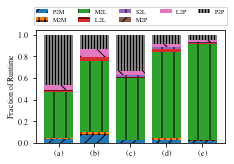

In [15]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

patterns = [ "//" , "++" , "|" , "-" , "+" , "x", "\\", "||||" ]

xvalues = [
    f"ExaFMM-T p={evec[0].config['order_equivalent']}", 
    f"ExaFMM-T p={evec[1].config['order_equivalent']}", 
    f"PyExaFMM K={evec[0].config['target_rank']} p={evec[0].config['order_equivalent']}",
    f"PyExaFMM K={evec[1].config['target_rank']} p={evec[1].config['order_equivalent']}"
]

xvalues = [
    '(a)', '(b)', '(c)', '(d)', '(e)'
]

p2m =  np.array(
    [
        etimes[0]['P2M']/etimevec[0], 
        etimes[1]['P2M']/etimevec[1], 
        evec[0].times['P2M']/ptimevec[0],
        evec[2].times['P2M']/ptimevec[2],
        evec[1].times['P2M']/ptimevec[1]

    ]
)
plt.bar(xvalues, p2m, label='P2M', hatch=patterns[0], alpha=.99)

m2m = np.array(
    [
        etimes[0]['M2M']/etimevec[0], 
        etimes[1]['M2M']/etimevec[1], 
        evec[0].times['M2M']/ptimevec[0],
        evec[2].times['M2M']/ptimevec[2],
        evec[1].times['M2M']/ptimevec[1],
    ]
)
plt.bar(xvalues, m2m, label='M2M', bottom=p2m, hatch=patterns[1], alpha=.99)

bottom = m2m+p2m
m2l = np.array(
    [
        etimes[0]['M2L']/etimevec[0], 
        etimes[1]['M2L']/etimevec[1], 
        evec[0].times['M2L']/ptimevec[0],
        evec[2].times['M2L']/ptimevec[2],
        evec[1].times['M2L']/ptimevec[1],
    ]
)
plt.bar(xvalues, m2l, label='M2L', bottom=bottom, hatch=patterns[2], alpha=.99)

bottom += m2l
l2l = np.array(
    [
        etimes[0]['L2L']/etimevec[0], 
        etimes[1]['L2L']/etimevec[1], 
        evec[0].times['L2L']/ptimevec[0],
        evec[2].times['L2L']/ptimevec[2],
        evec[1].times['L2L']/ptimevec[1],
    ]
)
plt.bar(xvalues, l2l, label='L2L', bottom=bottom, hatch=patterns[3], alpha=.99)

bottom += l2l
s2l = np.array(
    [
        etimes[0]['S2L']/etimevec[0], 
        etimes[1]['S2L']/etimevec[1], 
        evec[0].times['S2L']/ptimevec[0],
        evec[2].times['S2L']/ptimevec[2],
        evec[1].times['S2L']/ptimevec[1],
    ]
)
plt.bar(xvalues, s2l, label='S2L', bottom=bottom, hatch=patterns[4], alpha=.99)

bottom += s2l
m2t = np.array(
    [
        etimes[0]['M2T']/etimevec[0], 
        etimes[1]['M2T']/etimevec[1], 
        evec[0].times['M2T']/ptimevec[0],
        evec[2].times['M2T']/ptimevec[2],
        evec[1].times['M2T']/ptimevec[1],
    ]
)
plt.bar(xvalues, m2t, label='M2P', bottom=bottom, hatch=patterns[5], alpha=.99)

bottom += m2t
l2t = np.array(
    [
        etimes[0]['L2T']/etimevec[0], 
        etimes[1]['L2T']/etimevec[1], 
        evec[0].times['L2T']/ptimevec[0],
        evec[2].times['L2T']/ptimevec[2],
        evec[1].times['L2T']/ptimevec[1],
    ])
plt.bar(xvalues, l2t, label='L2P', bottom=bottom, hatch=patterns[6], alpha=.99)

bottom += l2t
p2p = np.array(
    [
        etimes[0]['P2P']/etimevec[0], 
        etimes[1]['P2P']/etimevec[1], 
        evec[0].times['P2P']/ptimevec[0],
        evec[2].times['P2P']/ptimevec[2],
        evec[1].times['P2P']/ptimevec[1],
    ]
)
plt.bar(xvalues, p2p, label='P2P', bottom=bottom, hatch=patterns[7], alpha=.99)

plt.ylabel('Fraction of Runtime')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.23),
          ncol=5, fancybox=True, prop={'size': 6})
fig.set_size_inches(width, height)
fp = FIGURE_SAVEPATH  + '/operator_runtimes.pdf'
plt.savefig(fp, bbox_inches='tight')
plt.show()

In [16]:
100*m2l

array([42.66155115, 66.22456455, 57.04965187, 80.49467036, 89.28479777])

In [25]:
100*m2l

array([63.23172112, 78.7323146 ])

In [13]:
100*m2l

array([63.23541597, 89.07977604])

In [14]:
100*p2p

array([13.95743339,  4.68324192])

In [ ]:
etime

In [ ]:
ptime